In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.tsa.seasonal import seasonal_decompose
from tslearn.clustering import TimeSeriesKMeans

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
data = pd.read_csv('Weather Data.csv', parse_dates=['Date/Time'], index_col=[0])
data.sample()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
Date/Time,,,,,,,
2012-05-27 11:00:00,19.5,3.9,36,4,48.3,101.83,Cloudy


In [7]:
data.index.is_monotonic

True

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2012-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temp_C            8784 non-null   float64
 1   Dew Point Temp_C  8784 non-null   float64
 2   Rel Hum_%         8784 non-null   int64  
 3   Wind Speed_km/h   8784 non-null   int64  
 4   Visibility_km     8784 non-null   float64
 5   Press_kPa         8784 non-null   float64
 6   Weather           8784 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 549.0+ KB


In [9]:
data.duplicated().sum()

0

In [10]:
mapper = {
    'Temp_C':'temp_C',
    'Dew Point Temp_C':'dew_point_temp_C',
    'Rel Hum_%':'rel_hum_%',
    'Wind Speed_km/h':'wind_speed_km/h',
    'Visibility_km':'visibility_km',
    'Press_kPa':'press_kPa',
    'Weather':'weather'
}
data.rename(columns=mapper, inplace=True)
data.sample(2)

,temp_C,dew_point_temp_C,rel_hum_%,wind_speed_km/h,visibility_km,press_kPa,weather
Date/Time,,,,,,,
2012-05-27 08:00:00,15.6,3.1,43,11,48.3,101.94,Mostly Cloudy
2012-03-11 18:00:00,9.1,-1.0,49,7,25.0,101.68,Clear


In [11]:
data.describe(datetime_is_numeric=True).T

,count,mean,std,min,25%,50%,75%,max
temp_C,8784.0,8.798144,11.687883,-23.30,0.10,9.30,18.80,33.00
dew_point_temp_C,8784.0,2.555294,10.883072,-28.50,-5.90,3.30,11.80,24.40
rel_hum_%,8784.0,67.431694,16.918881,18.00,56.00,68.00,81.00,100.00
wind_speed_km/h,8784.0,14.945469,8.688696,0.00,9.00,13.00,20.00,83.00
visibility_km,8784.0,27.664447,12.622688,0.20,24.10,25.00,25.00,48.30
press_kPa,8784.0,101.051623,0.844005,97.52,100.56,101.07,101.59,103.65


array([[<AxesSubplot:title={'center':'temp_C'}>,
        <AxesSubplot:title={'center':'dew_point_temp_C'}>],
       [<AxesSubplot:title={'center':'rel_hum_%'}>,
        <AxesSubplot:title={'center':'wind_speed_km/h'}>],
       [<AxesSubplot:title={'center':'visibility_km'}>,
        <AxesSubplot:title={'center':'press_kPa'}>]], dtype=object)

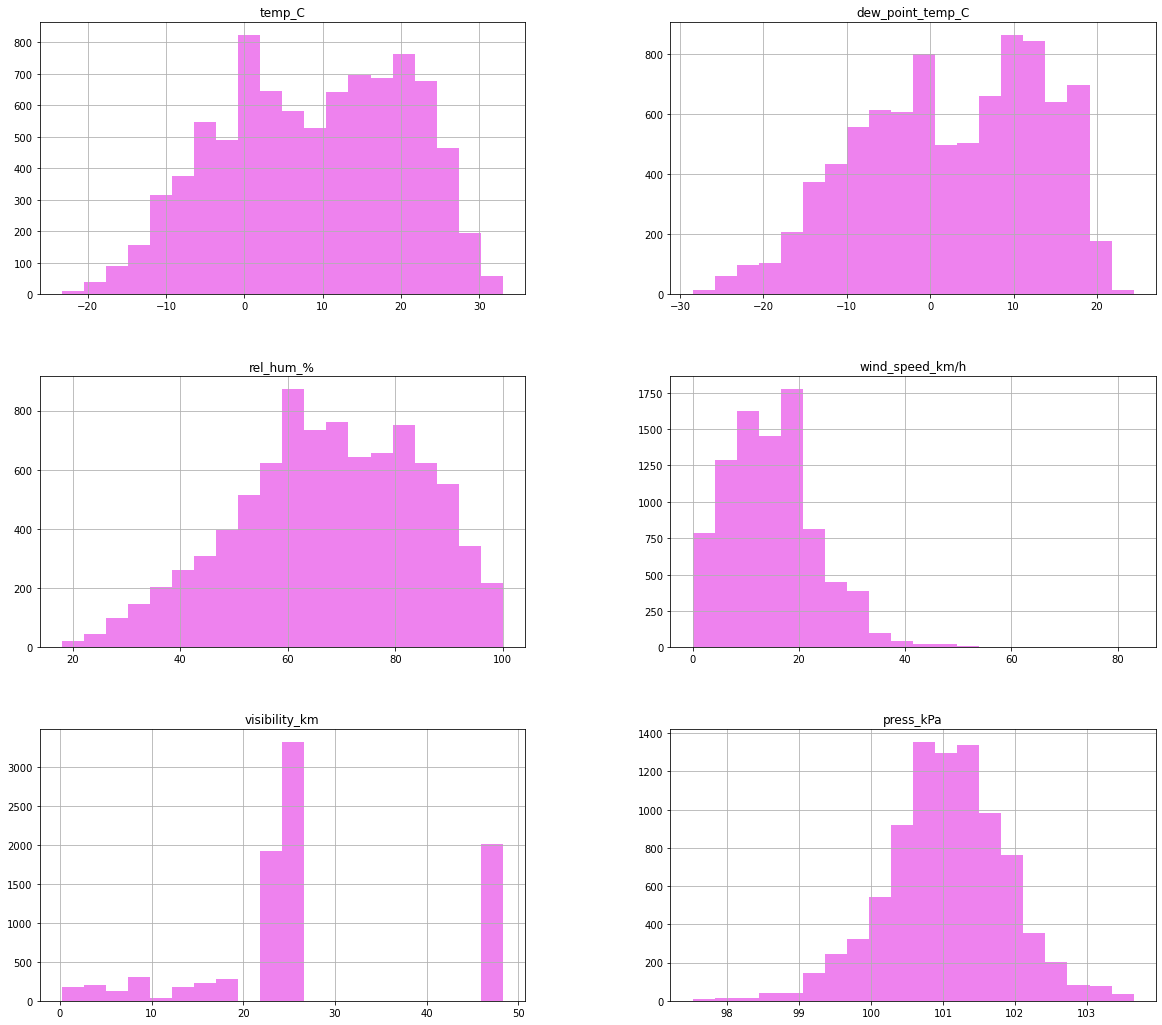

In [12]:
data.hist(bins = 20, figsize = (20, 18), color = 'violet')

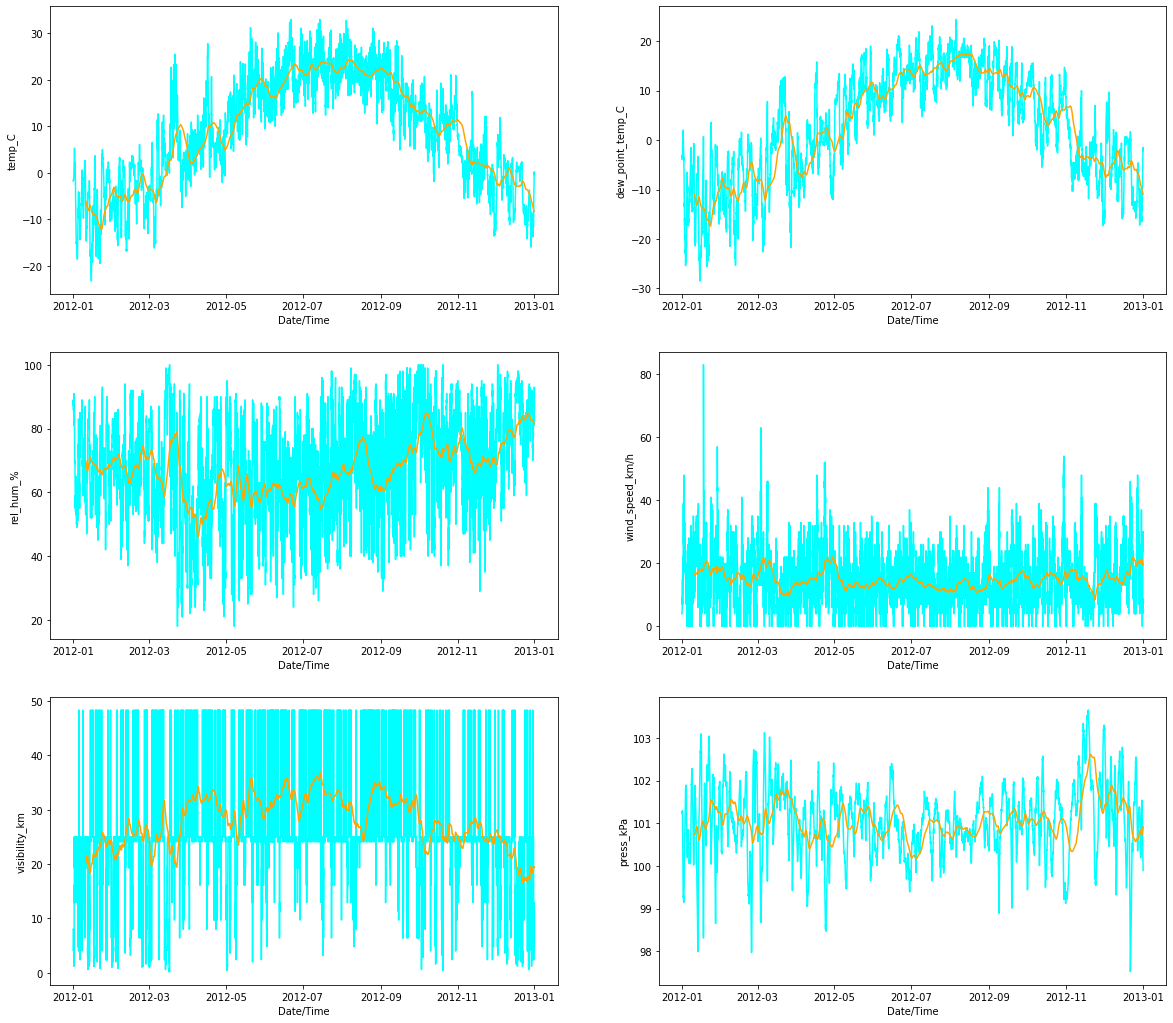

In [13]:
data_rolling = data.drop('weather', axis=1).rolling(240).mean()


plt.figure(figsize=(20,18))
col = 1
for i in data.drop('weather', axis=1).columns:
    plt.subplot(3, 2, col)
    sns.lineplot(data=data, x='Date/Time', y=i, color='cyan')
    sns.lineplot(data=data_rolling, x='Date/Time', y=i, color='orange')
    col += 1

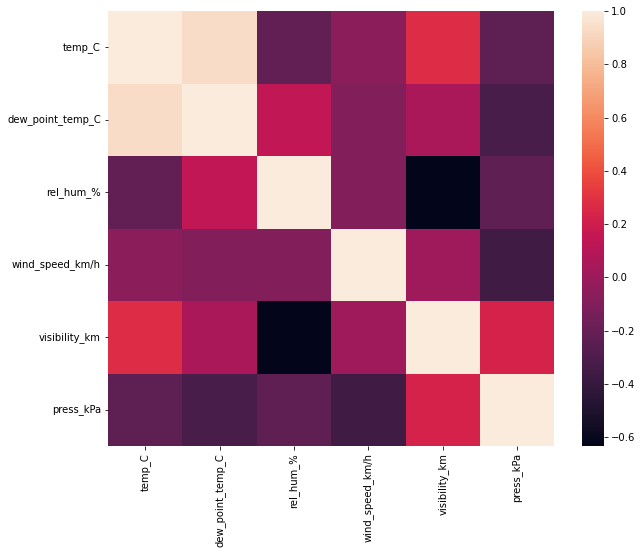

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(data[data.columns[:6]].corr());

In [15]:
data['weather'].nunique()

50

In [16]:
corpus = data['weather']
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(corpus)

weather_tfidf = pd.DataFrame(data=vectors.toarray(), index=corpus.index, columns=vectorizer.get_feature_names_out())
weather_tfidf.shape

(8784, 18)

In [17]:
weather_tfidf.sample(3)

,blowing,clear,cloudy,drizzle,fog,freezing,grains,haze,heavy,ice,mainly,moderate,mostly,pellets,rain,showers,snow,thunderstorms
Date/Time,,,,,,,,,,,,,,,,,,
2012-11-02 17:00:00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2012-05-13 20:00:00,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2012-10-04 14:00:00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


blowing


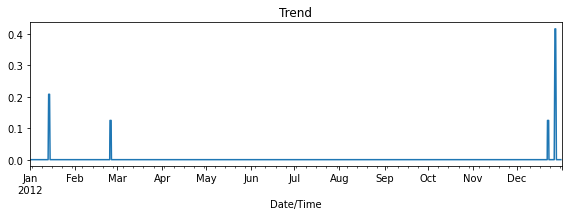

clear


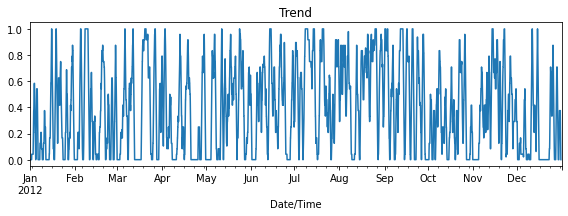

cloudy


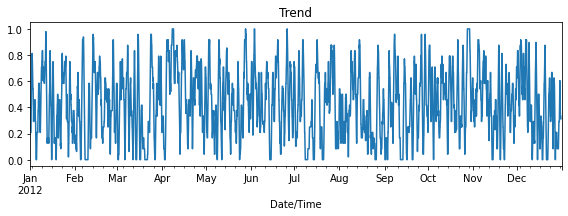

drizzle


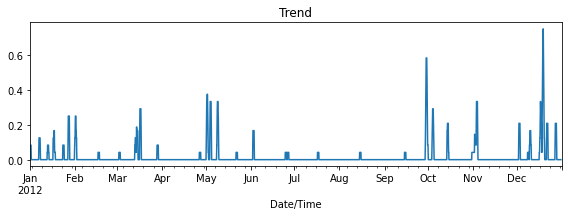

fog


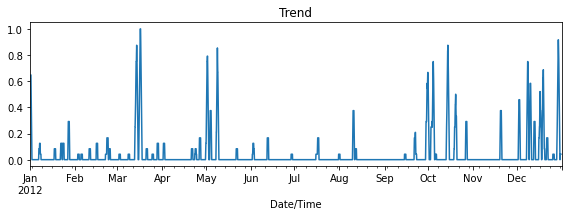

freezing


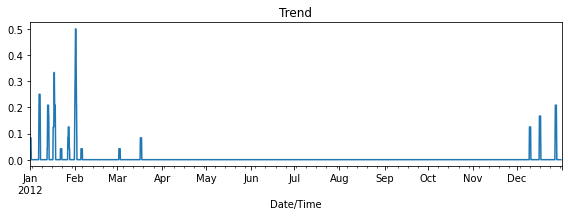

grains


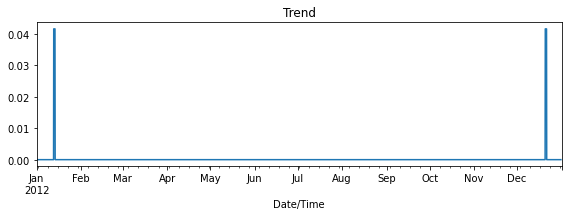

haze


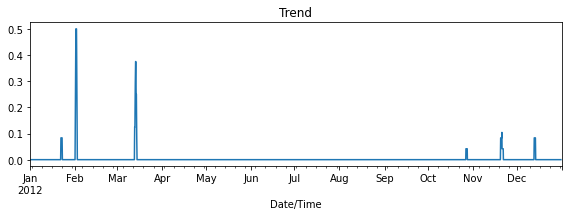

heavy


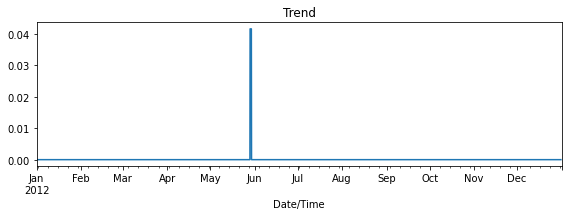

ice


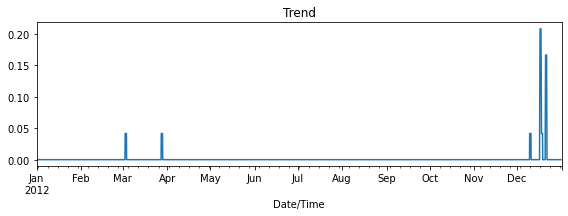

mainly


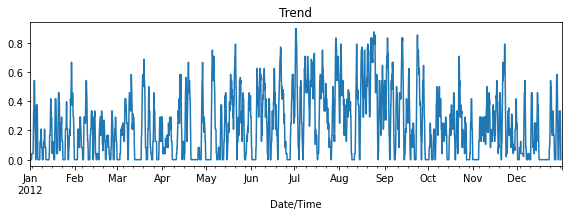

moderate


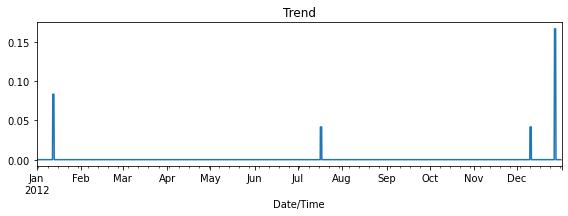

mostly


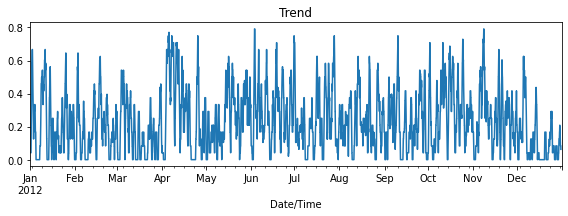

pellets


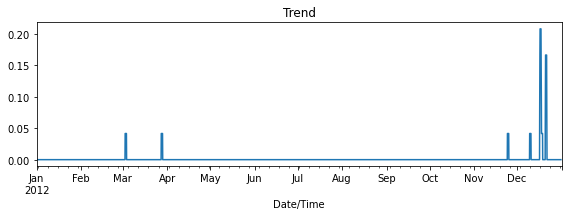

rain


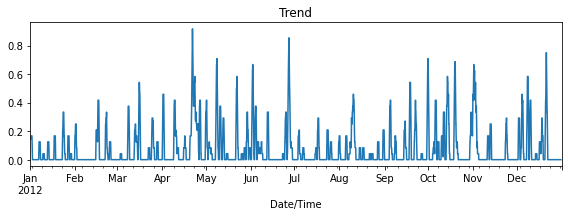

showers


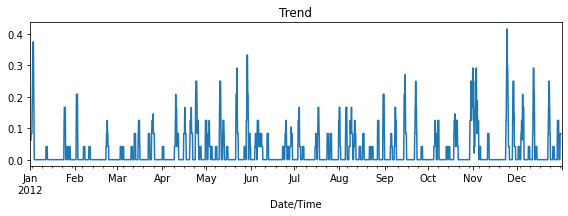

snow


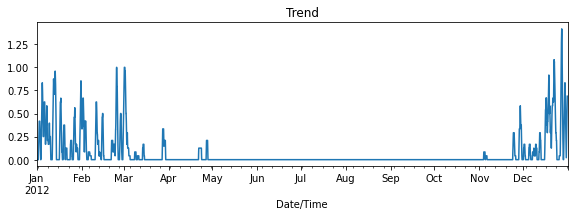

thunderstorms


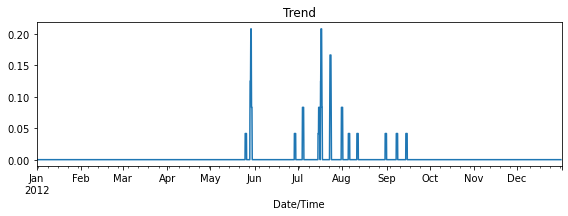

In [18]:
for i in weather_tfidf.columns:
    print(i)
    decomposed = seasonal_decompose(weather_tfidf[i])
    
    plt.figure(figsize=(8, 8))

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.tight_layout()
    plt.show()

In [19]:
weather_tfidf.drop(['mainly', 'mostly', 'moderate'], axis=1, inplace=True)

In [20]:
weather_col = list(weather_tfidf.columns)
weather_col.append('label')

metrics_col = list(data.drop('weather', axis=1).columns)
metrics_col.append('label')

X = data.drop('weather', axis=1)
df = X.join(weather_tfidf)
X = df.copy()
X =StandardScaler().fit_transform(X)

df.sample()

,temp_C,dew_point_temp_C,rel_hum_%,wind_speed_km/h,visibility_km,press_kPa,blowing,clear,cloudy,drizzle,...,freezing,grains,haze,heavy,ice,pellets,rain,showers,snow,thunderstorms
Date/Time,,,,,,,,,,,,,,,,,,,,,
2012-03-03 12:00:00,5.2,-3.0,55,37,48.3,98.82,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
model = TimeSeriesKMeans(n_clusters=3, random_state=12345)
model.fit(X)

TimeSeriesKMeans(random_state=12345)

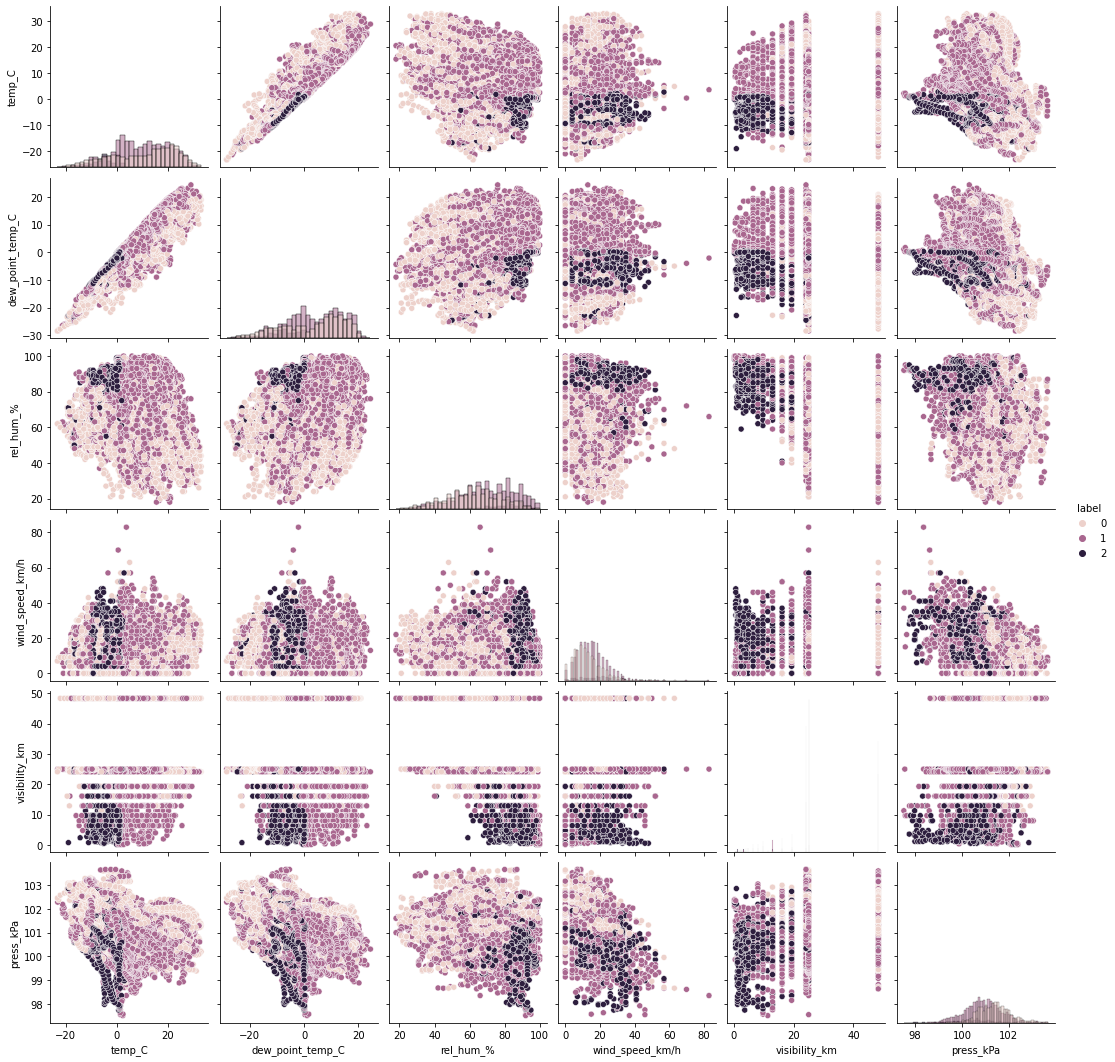

In [22]:
df['label'] = model.labels_

sns.pairplot(df[metrics_col], hue='label', diag_kind='hist');

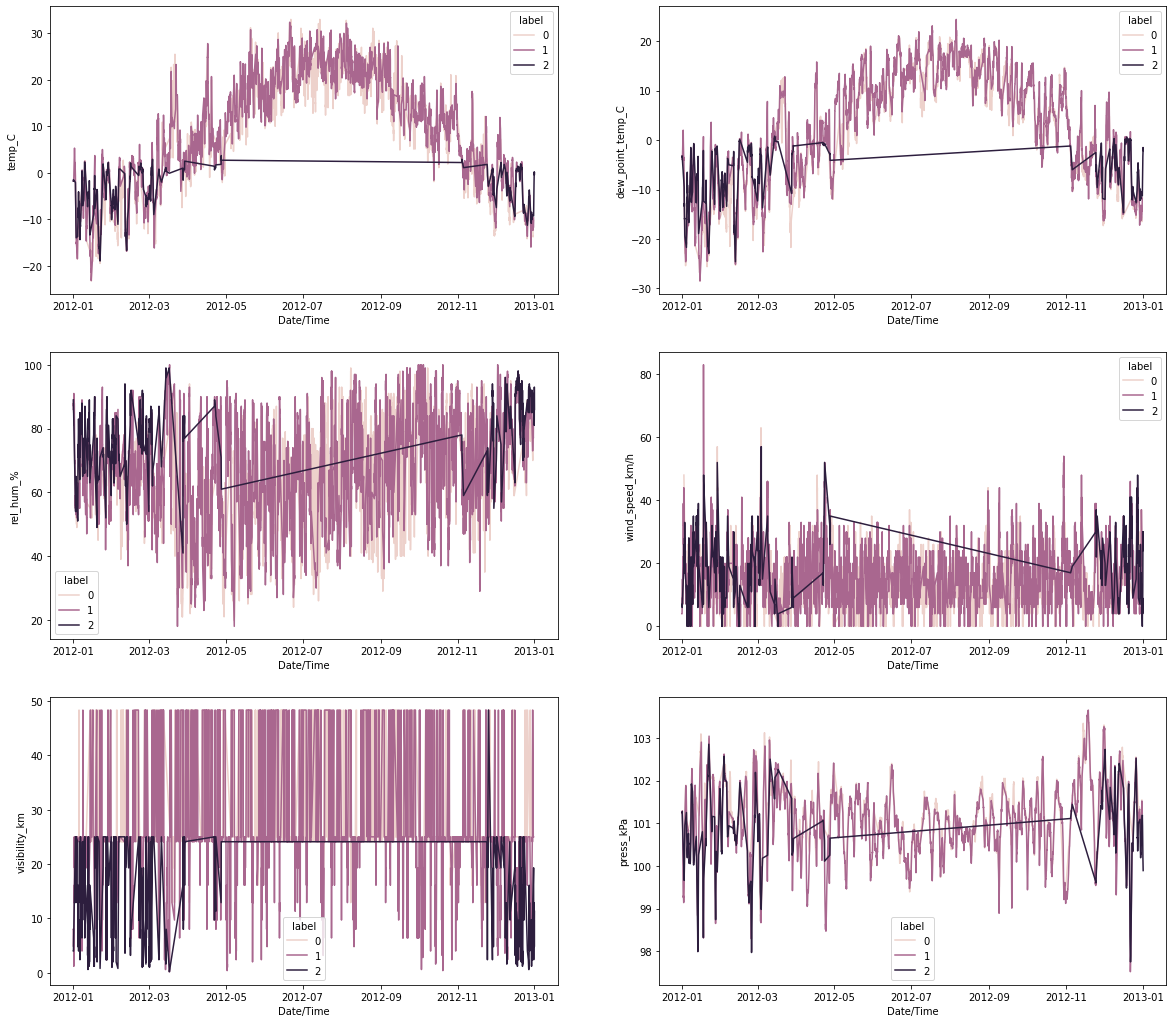

In [23]:
plt.figure(figsize=(20,18))
col = 1
for i in metrics_col[:6]:
    plt.subplot(3, 2, col)
    sns.lineplot(data=df, x='Date/Time', y=i, hue='label', color='cyan')
    col += 1

In [24]:
def weather_cloud(label):
    cloud = []
    for col in label.index:
        num = round(label[col])
        if num > 0:
            cloud.append((col+' ')*num)
    return ''.join(cloud)

In [25]:
weather_per_label = df[weather_col].groupby('label').sum()

weather_per_label

,blowing,clear,cloudy,drizzle,fog,freezing,grains,haze,heavy,ice,pellets,rain,showers,snow,thunderstorms
label,,,,,,,,,,,,,,,
0,0,3432,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,3797,121,353,0,0,19,1,0,0,640,210,0,27
2,21,0,0,45,73,53,2,10,0,13,14,49,68,604,0


In [29]:
df[metrics_col].groupby('label').describe().T

label                             0            1           2
temp_C           count  3432.000000  4726.000000  626.000000
                 mean     10.343823     9.384067   -4.099361
                 std      12.577530    10.613273    4.169539
                 min     -23.300000   -23.200000  -19.000000
                 25%       0.100000     1.800000   -6.800000
                 50%      13.100000     9.700000   -4.400000
                 75%      20.900000    18.200000    0.000000
                 max      33.000000    32.400000    3.700000
dew_point_temp_C count  3432.000000  4726.000000  626.000000
                 mean      2.846008     3.600656   -6.930511
                 std      11.615842    10.289809    4.942260
                 min     -28.500000   -28.500000  -24.600000
                 25%      -6.700000    -3.600000   -9.975000
                 50%       6.000000     4.000000   -6.950000
                 75%      12.500000    12.100000   -2.900000
                 max      21.200000    24.400000    0.800000
rel_hum_%        count  3432.000000  4726.000000  626.000000
                 mean     62.147145    69.460008   81.091054
                 std      16.035361    16.827025    9.954762
                 min      20.000000    18.000000   41.000000
                 25%      51.000000    58.000000   75.000000
                 50%      63.000000    71.000000   83.000000
                 75%      74.000000    83.000000   89.000000
                 max      99.000000   100.000000   99.000000
wind_speed_km/h  count  3432.000000  4726.000000  626.000000
                 mean     12.758741    15.849767   20.107029
                 std       7.961841     8.492852   10.415667
                 min       0.000000     0.000000    0.000000
                 25%       7.000000     9.000000   11.000000
                 50%      11.000000    15.000000   20.000000
                 75%      17.000000    20.000000   28.000000
                 max      63.000000    83.000000   57.000000
visibility_km    count  3432.000000  4726.000000  626.000000
                 mean     32.676282    26.276767   10.663738
                 std      11.419263    11.563077    8.392668
                 min      11.300000     0.200000    0.200000
                 25%      25.000000    24.100000    3.600000
                 50%      25.000000    25.000000    8.000000
                 75%      48.300000    25.000000   16.100000
                 max      48.300000    48.300000   48.300000
press_kPa        count  3432.000000  4726.000000  626.000000
                 mean    101.379659   100.886858  100.497093
                 std       0.708526     0.828685    0.979197
                 min      98.670000    97.520000   97.750000
                 25%     100.890000   100.370000  100.012500
                 50%     101.370000   100.890000  100.590000
                 75%     101.820000   101.410000  101.140000
                 max     103.630000   103.650000  102.850000